## Meta-Optimization Using Many Problems

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/MetaOps) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsl1877BS8m3yt8t_wq2IWji)

## Introduction

In the previous two papers, we tuned the parameters of Differential Evolution (DE) to work well on a single problem. This resulted in superior performance on that particular problem, but it may also cause worse performance on other problems.

When developing a new optimization method, we need to provide the end-user with a good default choice of control parameters, that have been tuned to work well on a wide range of problems. This hopefully increases the chance that the optimizer will perform well on new problems in the future.

We could use the Bayesian Meta-Optimizer from the [first paper](https://github.com/Hvass-Labs/MetaOps/blob/master/01_Bayesian_Meta-Optimization.ipynb) with multiple problems, simply by summing the meta-fitness for different problems into a single aggregate meta-fitness that must then be meta-optimized. The advantage of this approach is that it is very simple. The disadvantage is that different problems may have radically different fitness-ranges, which could cause harmful interference when summing their fitness values.

Another approach which we will use in this paper, is to use Multi-Objective Meta-Optimization similar to the [second paper](https://github.com/Hvass-Labs/MetaOps/blob/master/02_Multi-Objective_Meta-Optimization.ipynb), but instead of having multiple objectives for a single problem, we will use several different benchmark problems. The implementation is very similar to the second paper and most of the source-code has simply been reused here.

## Flowchart

The flowchart below shows the rough idea. We use the NSGA-2 algorithm (Non-Dominated Sorting Genetic Algorithm version 2) to propose new parameters for the DE optimizer. We then perform e.g. 32 optimization runs on each of 5 problems using these parameters and record the mean fitness after some number of evaluations. These are the 5 meta-fitness measures that we send back to the NSGA-2 so it can evaluate how well the DE parameters performed and suggest new parameters to be tried. This is repeated until the best DE parameters have been found.

![Flowchart](images/03_flowchart_many_problems.png)

## Imports

In [1]:
# Normal packages.
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp
import functools

# Heuristic optimizers such as DE, PSO and NSGA-2.
# This is actually implemented in C++ so it should run very fast.
import pygmo as pg

In [2]:
pg.__version__

'2.9'

## Problem Settings

We will use benchmark problems from the CEC 2014 competition set. These are the available problems:

In [3]:
for prob_id in range(1, 29):
    problem = pg.problem(pg.problems.cec2014(prob_id=prob_id, dim=10))
    print(problem.get_name())

CEC2014 - f1(ellips_func)
CEC2014 - f2(bent_cigar_func)
CEC2014 - f3(discus_func)
CEC2014 - f4(rosenbrock_func)
CEC2014 - f5(ackley_func)
CEC2014 - f6(weierstrass_func)
CEC2014 - f7(griewank_func)
CEC2014 - f8(rastrigin_func_non_rotated)
CEC2014 - f9(rastrigin_func)
CEC2014 - f10(schwefel_func_non_rotated)
CEC2014 - f11(schwefel_func)
CEC2014 - f12(katsuura_func)
CEC2014 - f13(happycat_func)
CEC2014 - f14(hgbat_func)
CEC2014 - f15(grie_rosen_func)
CEC2014 - f16(escaffer6_func)
CEC2014 - f17(hf01)
CEC2014 - f18(hf02)
CEC2014 - f19(hf03)
CEC2014 - f20(hf04)
CEC2014 - f21(hf05)
CEC2014 - f22(hf06)
CEC2014 - f23(cf01)
CEC2014 - f24(cf02)
CEC2014 - f25(cf03)
CEC2014 - f26(cf04)
CEC2014 - f27(cf05)
CEC2014 - f28(cf06)


In [4]:
# Dimensionality of each problem.
dim = 10

# List of problem id's we will be using.
# These must be between 1 and 28 (inclusive).
problem_ids = [1, 2, 3, 4, 5]

# Number of problems.
num_problems = len(problem_ids)

# List of problem instances that must be optimized.
problems = [pg.problem(pg.problems.cec2014(prob_id=id, dim=dim))
            for id in problem_ids]

# Number of fitness evaluations for one optimization run.
num_fitness_evals = 10000

# Number of optimization runs to perform on each problem, for each
# new choice of parameters for the optimizer. This should not be
# too low because the optimizer is stochastic so we need to average
# out the performance over many runs. But it should not be too high.
# This should be a multiple of the number of CPU cores because
# we run it in parallel using all available CPU cores.
num_runs = 32

## Optimizer Parameters

In this example, we will use [Differential Evolution (DE)](https://en.wikipedia.org/wiki/Differential_evolution) as the heuristic optimizer whose parameters we want to tune. We first need to setup the search-space dimensions for the parameters. We will use the NSGA-2 implementation from Pygmo as the meta-optimizer, which requires the search-space to be defined as floating-point arrays.

In [5]:
# Names for the parameters.
# This is actually not used in the code below, but is merely
# included here as a reminder of the dimensions.
dimension_names = ["pop_size", "F", "CR", "variant"]

In [6]:
# Example of a default choice of parameters.
default_parameters = [100, 0.8, 0.9, 2]

In [7]:
# Lower and upper boundaries for the parameters.
params_min = [5.0, 0.0, 0.0, 1.0]
params_max = [200.0, 1.0, 1.0, 10.0]

In [8]:
def unpack_parameters(params):
    """
    Unpack an array of floats to the individual parameters
    of the proper type. Note that the parameters CR and F
    are rounded to 2 decimals, which works together with
    the meta_fitness() function and its decorator @lru_cache
    as explained further below.
    """

    pop_size = int(params[0] + 0.5)     # int
    CR = round(params[1], 2)            # float with 2 decimals
    F = round(params[2], 2)             # float with 2 decimals
    variant = int(params[3] + 0.5)      # int
    
    return pop_size, CR, F, variant

In [9]:
# Names of the optimizer variants used for printing.
variant_names = \
{
     1: "best/1/exp",
     2: "rand/1/exp",
     3: "rand-to-best/1/exp",
     4: "best/2/exp",
     5: "rand/2/exp",
     6: "best/1/bin",
     7: "rand/1/bin",
     8: "rand-to-best/1/bin",
     9: "best/2/bin",
     10: "rand/2/bin"    
}

In [10]:
def print_parameters(pop_size, CR, F, variant):
    """Print the given parameters for the DE optimizer."""

    print("pop_size:", pop_size)
    print("CR: {0:.2f}".format(CR))
    print("F: {0:.2f}".format(F))
    print("variant: {0} ({1})".format(variant,
                                      variant_names[variant]))

In [11]:
def print_parameters_raw(params):
    """
    Print the given parameters for the DE optimizer.
    The parameters are passed as a list of floats.
    """

    # Unpack the parameters.
    pop_size, CR, F, variant = unpack_parameters(params)

    # Print them.
    print_parameters(pop_size=pop_size, CR=CR, F=F, variant=variant)

## Parallel Optimization Runs

Calculating the meta-fitness for a single problem, requires us to perform a number of optimization runs on that problem and average the best-found fitness values from those runs. To speed up the execution we perform these optimization runs in parallel.

This could have been implemented more elegantly using a function `parallel_run()` with a sub-function `_single_run()` but that did not seem to work.

In [12]:
class ParallelRunner:
    """Perform a number of optimization runs in parallel."""
    
    def __init__(self, problem, num_generations,
                 pop_size, CR, F, variant):
        # Copy parameters for optimizer.
        self.problem = problem
        self.num_generations = num_generations
        self.pop_size = pop_size
        self.CR = CR
        self.F = F
        self.variant = variant

    def _single_run(self, i):
        """
        Perform a single optimization run and return the best fitness.
        
        :param i: Parallel job number. Ignored here.
        :return: Best fitness found.
        """

        # Create a new instance of the optimizer using
        # the given parameters.
        uda = pg.de(gen=self.num_generations,
                    CR=self.CR, F=self.F, variant=self.variant)
        optimizer = pg.algorithm(uda=uda)

        # Create a population of agents for the optimizer.
        population = pg.population(prob=self.problem,
                                   size=self.pop_size)

        # Evolve the optimizer's population.
        population = optimizer.evolve(population)

        # Best fitness found in this optimization run.
        fitness = population.champion_f[0]

        return fitness

    def run(self):
        """Perform the optimization runs in parallel."""

        # Create a pool of workers sized according to the CPU cores available.
        pool = mp.Pool()

        # Calculate the fitness for each agent in parallel.
        fitnesses = pool.map(self._single_run, range(num_runs))

        # Close the pool of workers and wait for them all to finish.
        pool.close()
        pool.join()
        
        return fitnesses

## Meta-Fitness

The meta-fitness function performs a number of optimization runs with the given choice of parameters and evaluates their performance on each of the benchmark problems.

In [13]:
@functools.lru_cache()
def meta_fitness(pop_size, CR, F, variant):
    """
    Meta-fitness for evaluating the performance of the DE optimizer
    with the given parameters on several benchmark problems.

    Note the function-decorator @functools.lru_cache which
    caches the results of previous calls to this function.
    This is because the NSGA-2 meta-optimizer calls this
    function with identical parameters many times, and although
    the result is stochastic so it may improve slightly, it
    wastes a lot of computation to calculate very similar
    meta-fitness values for identical parameters. By using cached
    results we save about 80% of the computation time.
    To effectively use the caching, the parameters pop_size and
    variant are integers and the parameters CR and F have been
    rounded to 2 decimals in the unpack_parameters() function.

    :param pop_size: Population size.
    :param CR: Control-parameter CR (crossover probability).
    :param F: Control-parameter F (differential weight).
    :param variant: DE variant, integer between 1 and 10.
    :return: Array of floats for the meta-fitness objectives.
    """

    def _run(problem):
        """Helper-function for performing optimization runs."""

        # Create the job-runner for doing the optimization runs.
        runner = ParallelRunner(problem=problem,
                                num_generations=num_generations,
                                pop_size=pop_size,
                                CR=CR, F=F, variant=variant)
        
        # Perform the optimization runs in parallel.
        # This returns a list of the best fitness-values found
        # for each of the optimization runs.
        fitnesses = runner.run()
        
        # The meta-fitness measure of how well the optimizer
        # performed with those parameters, averaged over
        # several optimization runs.
        meta_fitness = np.mean(fitnesses)
        
        return meta_fitness

    # Print parameters.
    print_parameters(pop_size=pop_size, CR=CR, F=F, variant=variant)
    
    # Number of iterations for the optimizer's population.
    # This ensures that we perform the same number of
    # evaluations of the problem's fitness function
    # regardless of the population-size.
    num_generations = num_fitness_evals // pop_size

    # Perform the optimization runs and get their meta-fitness.
    meta_fitness = [_run(problem) for problem in problems]
    meta_fitness = np.array(meta_fitness)

    # Print the meta-fitness.
    print(np.array2string(meta_fitness, precision=2))
    print()

    # Return array with the multi-objective meta-fitness value.
    return meta_fitness

## Meta-Optimizer

We use NSGA-2 as the meta-optimizer for tuning the parameters of the DE algorithm so as to perform well on the multiple meta-fitness measures we defined above.

In order to get this working in Pygmo, we first need to wrap the above `meta_fitness()` function in this `MetaProblem` class that is compatible with Pygmo.

In [14]:
class MetaProblem:
    """
    Wrapper for the meta_fitness() function that connects it with
    the meta-optimizer. This is necessary when using the pygmo API.
    """

    def __init__(self):
        pass

    def fitness(self, params):
        """
        Calculate and return the meta-fitness values for
        the given parameters.
        """

        # Unpack the parameters.
        pop_size, CR, F, variant = unpack_parameters(params)
        
        # Calculate and return the meta-fitness values.
        return meta_fitness(pop_size=pop_size,
                            CR=CR, F=F, variant=variant)

    def get_bounds(self):
        """Get boundaries of the parameter search-space."""
        return params_min, params_max

    def get_nobj(self):
        """Get number of meta-fitness-objectives."""
        return num_problems

This is the function for doing the actual meta-optimization. It creates an instance of the `MetaProblem` class we just defined, and then runs NSGA-2 on it.

In [15]:
def meta_optimize(pop_size=40, num_generations=100):
    """
    Perform meta-optimization using NSGA-2 to find the
    best parameters of DE with regard to the
    multi-objective meta-fitness measure defined above.
    
    :param pop_size: Population size for NSGA-2.
    :param num_generations: Number of generations to run NSGA-2.
    :return: (best_meta_fitness: 2-dim numpy array,
              best_parameters: 2-dim numpy array)
    """

    # Create the meta-problem-instance.
    meta_problem = MetaProblem()

    # Create an NSGA-2 Multi-Objective meta-optimizer.
    optimizer = pg.algorithm(uda=pg.nsga2(gen=num_generations))
    
    # Create a population of candidate parameters for DE.
    population = pg.population(prob=meta_problem, size=pop_size)
    
    # Perform meta-optimization of DE parameters.
    population = optimizer.evolve(population)

    # Get the best-found parameters and meta-fitnesses.
    best_parameters = population.get_x()
    best_meta_fitness = population.get_f()

    # Sorted index for the meta-fitnesses.
    idx_sort = np.argsort(best_meta_fitness[:, 0])

    # Sort the best-found parameters and meta-fitnesses.
    best_parameters = best_parameters[idx_sort]
    best_meta_fitness = best_meta_fitness[idx_sort]
    
    return best_meta_fitness, best_parameters

## Run Meta-Optimization

We can now run the meta-optimization. This experiment took about an hour to run on my quad-core laptop PC. Depending on all the settings as well as the speed and number of CPU cores of your computer, this may take minutes, hours or days to run.

In [16]:
%%time
best_meta_fitness, best_parameters = \
    meta_optimize(pop_size=40, num_generations=100)

pop_size: 86
CR: 0.38
F: 0.28
variant: 4 (best/2/exp)
[7.07e+05 1.91e+04 8.57e+02 4.20e+02 5.20e+02]

pop_size: 73
CR: 0.72
F: 0.66
variant: 4 (best/2/exp)
[2.08e+06 3.14e+06 1.35e+03 4.31e+02 5.20e+02]

pop_size: 46
CR: 0.25
F: 0.26
variant: 3 (rand-to-best/1/exp)
[8.08e+05 3.09e+04 9.29e+02 4.22e+02 5.20e+02]

pop_size: 160
CR: 0.98
F: 0.13
variant: 5 (rand/2/exp)
[3.19e+06 1.71e+06 5.31e+02 4.41e+02 5.20e+02]

pop_size: 105
CR: 0.08
F: 0.46
variant: 3 (rand-to-best/1/exp)
[1.58e+06 5.52e+06 1.75e+03 4.24e+02 5.20e+02]

pop_size: 86
CR: 0.98
F: 0.58
variant: 10 (rand/2/bin)
[1.43e+06 2.40e+08 1.37e+03 4.76e+02 5.21e+02]

pop_size: 38
CR: 0.33
F: 0.96
variant: 3 (rand-to-best/1/exp)
[1.45e+06 1.57e+04 1.41e+03 4.13e+02 5.20e+02]

pop_size: 86
CR: 0.91
F: 0.11
variant: 3 (rand-to-best/1/exp)
[8.24e+06 5.89e+07 2.76e+03 5.69e+02 5.20e+02]

pop_size: 44
CR: 0.40
F: 0.89
variant: 9 (best/2/bin)
[3.80e+06 2.20e+07 3.21e+03 4.40e+02 5.20e+02]

pop_size: 58
CR: 0.80
F: 0.84
variant: 7 (rand/

[2.55e+06 7.46e+04 1.77e+03 4.15e+02 5.20e+02]

pop_size: 8
CR: 0.32
F: 0.63
variant: 7 (rand/1/bin)
[42526.6    203.17   300.     423.73   519.06]

pop_size: 54
CR: 0.46
F: 0.25
variant: 4 (best/2/exp)
[384535.55   1126.93   1066.65    427.06    520.22]

pop_size: 56
CR: 0.65
F: 0.23
variant: 3 (rand-to-best/1/exp)
[9.58e+05 1.69e+05 5.51e+02 4.36e+02 5.20e+02]

pop_size: 54
CR: 0.90
F: 0.41
variant: 4 (best/2/exp)
[623.47 200.02 300.   408.7  520.34]

pop_size: 155
CR: 0.66
F: 0.23
variant: 9 (best/2/bin)
[52096.15  3293.66   303.23   433.79   520.52]

pop_size: 127
CR: 0.06
F: 0.70
variant: 5 (rand/2/exp)
[4.15e+06 8.91e+07 4.21e+03 4.53e+02 5.20e+02]

pop_size: 160
CR: 0.98
F: 0.09
variant: 5 (rand/2/exp)
[4.56e+06 1.44e+07 2.96e+03 4.65e+02 5.20e+02]

pop_size: 156
CR: 0.90
F: 0.44
variant: 9 (best/2/bin)
[1893.33 1543.63  300.08  425.33  520.45]

pop_size: 8
CR: 0.45
F: 0.63
variant: 4 (best/2/exp)
[3.52e+05 1.66e+03 3.19e+02 4.01e+02 5.20e+02]

pop_size: 73
CR: 0.38
F: 0.28
vari

[54832.5    200.     300.     418.47   520.15]

pop_size: 5
CR: 0.27
F: 0.63
variant: 6 (best/1/bin)
[1.58e+06 1.44e+08 4.44e+03 4.79e+02 5.20e+02]

pop_size: 13
CR: 0.83
F: 0.64
variant: 9 (best/2/bin)
[1429.52  200.    300.    427.17  520.56]

pop_size: 11
CR: 0.46
F: 0.52
variant: 4 (best/2/exp)
[190741.86    355.04    309.91    401.44    520.08]

pop_size: 11
CR: 0.69
F: 0.70
variant: 2 (rand/1/exp)
[40537.65   200.25   300.     401.34   520.18]

pop_size: 7
CR: 0.51
F: 0.63
variant: 9 (best/2/bin)
[7378.88  200.    302.91  427.17  520.42]

pop_size: 92
CR: 0.78
F: 0.53
variant: 4 (best/2/exp)
[7.23e+05 4.50e+05 4.38e+02 4.16e+02 5.20e+02]

pop_size: 6
CR: 0.83
F: 0.63
variant: 9 (best/2/bin)
[48039.31  3376.44  6217.9    426.09   520.47]

pop_size: 187
CR: 0.83
F: 0.04
variant: 10 (rand/2/bin)
[4.09e+06 1.19e+07 1.81e+03 4.20e+02 5.21e+02]

pop_size: 9
CR: 0.30
F: 0.64
variant: 8 (rand-to-best/1/bin)
[33599.58   200.05   300.71   409.38   520.26]

pop_size: 8
CR: 0.70
F: 0.70
vari

[3.11e+07 2.47e+09 2.47e+04 7.88e+02 5.20e+02]

pop_size: 54
CR: 0.84
F: 0.42
variant: 10 (rand/2/bin)
[139443.37 113844.6     309.57    410.33    520.49]

pop_size: 8
CR: 0.49
F: 0.42
variant: 7 (rand/1/bin)
[5.34e+06 3.24e+08 4.28e+03 4.58e+02 5.20e+02]

pop_size: 8
CR: 0.30
F: 0.69
variant: 5 (rand/2/exp)
[9.56e+05 1.81e+03 1.92e+03 4.06e+02 5.20e+02]

pop_size: 171
CR: 0.84
F: 0.04
variant: 7 (rand/1/bin)
[3.96e+06 3.22e+07 1.95e+03 4.24e+02 5.21e+02]

pop_size: 10
CR: 0.31
F: 0.68
variant: 10 (rand/2/bin)
[4.46e+05 3.22e+02 3.01e+02 4.19e+02 5.20e+02]

pop_size: 14
CR: 0.83
F: 0.64
variant: 9 (best/2/bin)
[210.06 200.   300.   418.47 520.41]

pop_size: 9
CR: 0.70
F: 0.64
variant: 9 (best/2/bin)
[2665.86  200.    300.12  411.95  520.43]

pop_size: 8
CR: 0.70
F: 0.63
variant: 4 (best/2/exp)
[18890.97   200.     300.     410.86   520.16]

pop_size: 13
CR: 0.83
F: 0.53
variant: 8 (rand-to-best/1/bin)
[3.26e+06 6.24e+08 6.46e+03 5.49e+02 5.21e+02]

pop_size: 11
CR: 0.46
F: 0.54
variant

[7149.02  200.    355.78  409.95  520.15]

pop_size: 170
CR: 0.81
F: 0.03
variant: 2 (rand/1/exp)
[3.48e+06 1.31e+07 2.85e+03 4.22e+02 5.18e+02]

pop_size: 13
CR: 0.32
F: 0.65
variant: 6 (best/1/bin)
[26179.55   200.     300.     412.     520.26]

pop_size: 56
CR: 0.84
F: 0.41
variant: 4 (best/2/exp)
[796.52 202.22 300.   410.86 520.28]

pop_size: 173
CR: 0.90
F: 0.03
variant: 10 (rand/2/bin)
[6.14e+06 1.23e+08 2.83e+03 4.64e+02 5.16e+02]

pop_size: 174
CR: 0.83
F: 0.02
variant: 4 (best/2/exp)
[2.19e+07 9.53e+08 2.01e+04 5.37e+02 5.20e+02]

pop_size: 53
CR: 0.90
F: 0.42
variant: 7 (rand/1/bin)
[6823.72  209.49  300.    417.45  520.54]

pop_size: 170
CR: 0.83
F: 0.02
variant: 2 (rand/1/exp)
[3.00e+06 5.30e+07 4.18e+03 4.43e+02 5.20e+02]

pop_size: 8
CR: 0.83
F: 0.73
variant: 4 (best/2/exp)
[5943.17  200.    300.    408.71  520.2 ]

pop_size: 8
CR: 0.83
F: 0.70
variant: 9 (best/2/bin)
[362.18 200.04 793.68 426.09 520.59]

pop_size: 14
CR: 0.70
F: 0.64
variant: 4 (best/2/exp)
[48194.9    

[4.99e+05 4.76e+03 2.02e+03 4.03e+02 5.20e+02]

pop_size: 49
CR: 0.94
F: 0.41
variant: 5 (rand/2/exp)
[ 1477.2  14393.82   300.23   417.5    520.45]

pop_size: 11
CR: 0.31
F: 0.41
variant: 9 (best/2/bin)
[44144.42   200.01   300.68   418.57   520.25]

pop_size: 8
CR: 0.68
F: 0.52
variant: 4 (best/2/exp)
[13129.17   200.02   300.14   401.2    517.75]

pop_size: 55
CR: 0.83
F: 0.03
variant: 2 (rand/1/exp)
[8.85e+06 2.43e+08 8.33e+03 4.68e+02 5.20e+02]

pop_size: 167
CR: 0.88
F: 0.41
variant: 4 (best/2/exp)
[17549.14 17393.74   302.29   418.98   520.38]

pop_size: 172
CR: 0.83
F: 0.03
variant: 4 (best/2/exp)
[2.23e+07 6.23e+08 1.57e+04 5.03e+02 5.20e+02]

pop_size: 14
CR: 0.48
F: 0.67
variant: 7 (rand/1/bin)
[2.54e+05 2.18e+02 3.00e+02 4.19e+02 5.20e+02]

pop_size: 8
CR: 0.70
F: 0.69
variant: 4 (best/2/exp)
[39145.31   200.01   300.     418.47   519.97]

pop_size: 170
CR: 0.66
F: 0.53
variant: 9 (best/2/bin)
[1.96e+06 6.45e+06 1.63e+03 4.25e+02 5.20e+02]

pop_size: 13
CR: 0.84
F: 0.03
var

[5511.1   210.29  300.    426.09  520.29]

pop_size: 9
CR: 0.83
F: 0.64
variant: 3 (rand-to-best/1/exp)
[5.53e+06 7.10e+05 1.02e+03 4.65e+02 5.20e+02]

pop_size: 8
CR: 0.70
F: 0.70
variant: 10 (rand/2/bin)
[69415.58   412.68   300.01   400.13   520.49]

pop_size: 154
CR: 0.83
F: 0.64
variant: 9 (best/2/bin)
[3.02e+06 8.89e+07 1.92e+03 4.51e+02 5.21e+02]

pop_size: 31
CR: 0.81
F: 0.03
variant: 2 (rand/1/exp)
[2.07e+07 6.98e+08 7.74e+03 5.15e+02 5.20e+02]

pop_size: 173
CR: 0.28
F: 0.06
variant: 4 (best/2/exp)
[6.94e+05 2.99e+05 5.62e+03 4.36e+02 5.20e+02]

pop_size: 12
CR: 0.85
F: 0.66
variant: 9 (best/2/bin)
[1816.17  200.    300.    418.47  520.55]

pop_size: 50
CR: 0.90
F: 0.41
variant: 4 (best/2/exp)
[1131.69  200.    300.    418.47  519.36]

pop_size: 53
CR: 0.90
F: 0.39
variant: 4 (best/2/exp)
[1049.08  200.01  300.    417.39  520.33]

pop_size: 11
CR: 0.83
F: 0.70
variant: 4 (best/2/exp)
[10506.26   200.6    300.     418.48   520.2 ]

pop_size: 8
CR: 0.69
F: 0.70
variant: 4 (best

[40396.51   200.13   300.     408.79   520.14]

pop_size: 6
CR: 0.67
F: 0.50
variant: 4 (best/2/exp)
[40519.94   262.82   987.89   411.15   520.16]

pop_size: 13
CR: 0.68
F: 0.64
variant: 9 (best/2/bin)
[13596.79   200.04   300.     417.39   520.33]

pop_size: 52
CR: 0.90
F: 0.39
variant: 4 (best/2/exp)
[1139.11  200.    300.    418.47  520.18]

pop_size: 8
CR: 0.82
F: 0.53
variant: 4 (best/2/exp)
[9811.82  201.98  319.49  427.29  520.21]

pop_size: 8
CR: 0.71
F: 0.70
variant: 4 (best/2/exp)
[26670.96   200.04   300.     418.47   520.16]

pop_size: 11
CR: 0.67
F: 0.53
variant: 9 (best/2/bin)
[1845.82  200.    306.95  418.48  520.49]

pop_size: 49
CR: 0.66
F: 0.53
variant: 9 (best/2/bin)
[212772.38   1914.03    302.02    409.9     520.5 ]

pop_size: 12
CR: 0.97
F: 0.53
variant: 9 (best/2/bin)
[2.76e+06 3.07e+07 2.96e+03 4.39e+02 5.20e+02]

pop_size: 10
CR: 0.91
F: 0.39
variant: 9 (best/2/bin)
[1.97e+07 1.56e+09 1.47e+04 8.41e+02 5.21e+02]

pop_size: 54
CR: 0.69
F: 0.70
variant: 4 (best/

[7.00e+05 2.87e+03 8.53e+02 4.01e+02 5.20e+02]

pop_size: 11
CR: 0.26
F: 0.68
variant: 4 (best/2/exp)
[7.48e+05 1.77e+03 1.44e+03 4.05e+02 5.20e+02]

pop_size: 56
CR: 0.96
F: 0.39
variant: 9 (best/2/bin)
[ 63938.2  141279.04    305.55    430.21    520.53]

pop_size: 55
CR: 0.90
F: 0.54
variant: 4 (best/2/exp)
[1084.46 2854.37  300.06  417.43  520.31]

pop_size: 52
CR: 0.91
F: 0.39
variant: 4 (best/2/exp)
[9983.75  200.    300.    417.39  520.4 ]

pop_size: 9
CR: 0.83
F: 0.54
variant: 4 (best/2/exp)
[9809.6   214.69  384.75  434.78  520.18]

pop_size: 55
CR: 0.91
F: 0.64
variant: 9 (best/2/bin)
[8.91e+04 4.63e+05 3.07e+02 4.21e+02 5.21e+02]

pop_size: 11
CR: 0.90
F: 0.39
variant: 4 (best/2/exp)
[6.85e+06 1.96e+08 7.78e+03 4.90e+02 5.20e+02]

pop_size: 56
CR: 0.65
F: 0.52
variant: 9 (best/2/bin)
[289293.78   5458.42    305.21    418.51    520.48]

pop_size: 54
CR: 0.70
F: 0.53
variant: 4 (best/2/exp)
[3.32e+05 2.89e+04 3.29e+02 4.28e+02 5.20e+02]

pop_size: 51
CR: 0.91
F: 0.70
variant: 4

[1281.72  200.    300.    426.09  520.35]

pop_size: 49
CR: 0.91
F: 0.53
variant: 9 (best/2/bin)
[142.25 207.08 300.   427.17 520.53]

pop_size: 49
CR: 0.67
F: 0.52
variant: 8 (rand-to-best/1/bin)
[2429.18  200.02  300.    426.1   520.42]

pop_size: 11
CR: 0.97
F: 0.70
variant: 5 (rand/2/exp)
[39117.87   313.29   300.     400.01   520.4 ]

pop_size: 8
CR: 0.64
F: 0.68
variant: 4 (best/2/exp)
[2.11e+05 2.00e+02 3.00e+02 4.10e+02 5.20e+02]

pop_size: 49
CR: 0.86
F: 0.39
variant: 9 (best/2/bin)
[1387.6   200.    300.    427.02  520.5 ]

pop_size: 50
CR: 0.91
F: 0.39
variant: 9 (best/2/bin)
[ 790.54 2900.78  300.7   435.71  520.46]

pop_size: 55
CR: 0.91
F: 0.53
variant: 9 (best/2/bin)
[711.64 201.26 300.   427.17 520.55]

pop_size: 54
CR: 0.67
F: 0.40
variant: 4 (best/2/exp)
[149286.45    924.6     301.09    426.12    520.23]

pop_size: 13
CR: 0.91
F: 0.50
variant: 4 (best/2/exp)
[39179.72   236.15   316.95   403.46   520.29]

pop_size: 15
CR: 0.88
F: 0.68
variant: 4 (best/2/exp)
[3567.4 

[4789.22  200.    300.    434.78  520.42]

pop_size: 53
CR: 0.91
F: 0.41
variant: 9 (best/2/bin)
[1889.08  208.19  301.75  426.2   520.59]

pop_size: 56
CR: 0.90
F: 0.39
variant: 4 (best/2/exp)
[3920.72  200.38  300.    434.78  520.27]

pop_size: 55
CR: 0.91
F: 0.53
variant: 4 (best/2/exp)
[565.78 460.06 300.01 417.42 520.3 ]

pop_size: 52
CR: 0.91
F: 0.39
variant: 9 (best/2/bin)
[3292.58 1205.84  300.    417.68  520.54]

pop_size: 49
CR: 0.97
F: 0.52
variant: 9 (best/2/bin)
[100.   200.   300.   434.78 520.52]

pop_size: 8
CR: 0.68
F: 0.54
variant: 4 (best/2/exp)
[56476.75   200.01   300.     408.93   520.15]

pop_size: 11
CR: 0.70
F: 0.70
variant: 4 (best/2/exp)
[62751.92   205.32   300.     402.35   520.13]

pop_size: 44
CR: 0.70
F: 0.52
variant: 4 (best/2/exp)
[295176.07   5995.94    303.56    417.88    520.17]

pop_size: 14
CR: 0.90
F: 0.53
variant: 4 (best/2/exp)
[21188.     200.02   300.38   409.78   520.23]

pop_size: 8
CR: 0.86
F: 0.70
variant: 4 (best/2/exp)
[22155.7    200.0

[3655.28  200.02  300.    408.7   516.35]

pop_size: 56
CR: 0.91
F: 0.53
variant: 9 (best/2/bin)
[452.6  205.2  300.   418.47 520.44]

pop_size: 52
CR: 0.91
F: 0.34
variant: 4 (best/2/exp)
[2954.78  265.72  303.77  417.39  520.3 ]

pop_size: 11
CR: 0.66
F: 0.70
variant: 4 (best/2/exp)
[167549.78    217.5     300.      422.53    520.17]

pop_size: 56
CR: 0.92
F: 0.40
variant: 9 (best/2/bin)
[1259.46 3084.26  300.02  418.53  520.47]

pop_size: 49
CR: 0.90
F: 0.52
variant: 9 (best/2/bin)
[104.21 200.17 300.   434.78 520.49]

pop_size: 49
CR: 0.67
F: 0.40
variant: 4 (best/2/exp)
[232162.81    771.5     300.28    417.42    519.42]

pop_size: 50
CR: 0.90
F: 0.40
variant: 4 (best/2/exp)
[1472.52  200.    300.    418.47  520.29]

pop_size: 51
CR: 0.68
F: 0.70
variant: 4 (best/2/exp)
[1.23e+06 6.38e+05 7.61e+02 4.26e+02 5.20e+02]

pop_size: 9
CR: 0.67
F: 0.39
variant: 9 (best/2/bin)
[1.75e+06 9.95e+08 6.75e+03 4.58e+02 5.21e+02]

pop_size: 49
CR: 0.84
F: 0.71
variant: 9 (best/2/bin)
[8.53e+05 1

[1.65e+06 1.01e+06 7.62e+02 4.12e+02 5.20e+02]

pop_size: 11
CR: 0.91
F: 0.41
variant: 9 (best/2/bin)
[3.25e+07 2.82e+09 7.35e+03 5.76e+02 5.21e+02]

pop_size: 62
CR: 0.91
F: 0.39
variant: 9 (best/2/bin)
[11657.87   226.4    300.71   424.84   520.46]

pop_size: 52
CR: 0.99
F: 0.40
variant: 9 (best/2/bin)
[ 87229.18 227275.69   3704.29    431.59    520.52]

pop_size: 49
CR: 0.91
F: 0.52
variant: 4 (best/2/exp)
[214.59 223.91 300.   427.17 520.38]

pop_size: 10
CR: 0.89
F: 0.52
variant: 9 (best/2/bin)
[1.19e+05 3.60e+06 1.20e+03 4.26e+02 5.21e+02]

pop_size: 47
CR: 0.71
F: 0.41
variant: 9 (best/2/bin)
[2249.73  200.    300.    426.09  520.5 ]

pop_size: 50
CR: 0.91
F: 0.40
variant: 9 (best/2/bin)
[2797.98  201.36  300.    437.54  520.54]

pop_size: 54
CR: 0.91
F: 0.40
variant: 4 (best/2/exp)
[780.8  200.03 300.   426.09 519.96]

pop_size: 49
CR: 0.69
F: 0.52
variant: 9 (best/2/bin)
[82624.43   502.2    300.46   418.52   520.4 ]

pop_size: 10
CR: 0.92
F: 0.42
variant: 9 (best/2/bin)
[2.20

[5750.66  200.    301.92  426.09  520.46]

pop_size: 7
CR: 0.83
F: 0.40
variant: 4 (best/2/exp)
[7.84e+05 6.13e+08 7.78e+03 4.66e+02 5.20e+02]

pop_size: 51
CR: 0.91
F: 0.68
variant: 9 (best/2/bin)
[2.35e+05 5.30e+06 3.61e+02 4.42e+02 5.20e+02]

pop_size: 49
CR: 0.64
F: 0.40
variant: 9 (best/2/bin)
[16060.08   200.04   300.     426.11   520.58]

pop_size: 56
CR: 0.94
F: 0.39
variant: 9 (best/2/bin)
[64051.12  1203.88   302.12   427.66   520.5 ]

pop_size: 49
CR: 0.67
F: 0.40
variant: 9 (best/2/bin)
[3769.03  200.    300.    434.78  520.56]

pop_size: 11
CR: 0.67
F: 0.39
variant: 4 (best/2/exp)
[109189.13    200.63    302.78    410.72    520.17]

pop_size: 50
CR: 0.91
F: 0.70
variant: 4 (best/2/exp)
[3.25e+05 3.68e+06 3.73e+02 4.16e+02 5.20e+02]

pop_size: 11
CR: 0.70
F: 0.52
variant: 9 (best/2/bin)
[1464.86  200.    300.01  434.78  520.54]

pop_size: 10
CR: 0.61
F: 0.71
variant: 4 (best/2/exp)
[138127.2     219.11    300.02    409.87    520.16]

pop_size: 12
CR: 0.83
F: 0.54
variant: 4

[134117.2     200.09    300.      408.71    520.14]

pop_size: 11
CR: 0.67
F: 0.69
variant: 4 (best/2/exp)
[102323.28    209.66    300.      417.47    518.8 ]

pop_size: 52
CR: 0.92
F: 0.54
variant: 4 (best/2/exp)
[151.44 404.47 300.   426.09 520.34]

pop_size: 10
CR: 0.70
F: 0.53
variant: 8 (rand-to-best/1/bin)
[4.88e+06 7.08e+08 1.44e+04 7.44e+02 5.21e+02]

pop_size: 8
CR: 0.61
F: 0.53
variant: 9 (best/2/bin)
[2586.52  200.    470.1   426.1   520.43]

pop_size: 8
CR: 0.70
F: 0.52
variant: 4 (best/2/exp)
[15929.21   200.     874.76   402.27   516.97]

pop_size: 50
CR: 0.83
F: 0.68
variant: 4 (best/2/exp)
[6.44e+05 8.81e+05 3.95e+02 4.15e+02 5.20e+02]

pop_size: 8
CR: 1.00
F: 0.52
variant: 4 (best/2/exp)
[3.47e+07 5.98e+09 2.63e+04 8.47e+02 5.20e+02]

pop_size: 7
CR: 0.91
F: 0.41
variant: 9 (best/2/bin)
[5.51e+07 4.35e+09 1.75e+04 8.61e+02 5.21e+02]

pop_size: 51
CR: 0.69
F: 0.53
variant: 4 (best/2/exp)
[6.32e+05 2.65e+04 3.26e+02 4.18e+02 5.20e+02]

pop_size: 11
CR: 0.66
F: 0.70
varia

[190873.83    724.65    302.32    409.98    520.18]

pop_size: 69
CR: 0.91
F: 0.40
variant: 9 (best/2/bin)
[384.5  210.03 300.   418.89 520.54]

pop_size: 6
CR: 0.70
F: 0.39
variant: 4 (best/2/exp)
[2.47e+06 1.66e+08 6.39e+03 4.55e+02 5.20e+02]

pop_size: 54
CR: 0.90
F: 0.52
variant: 4 (best/2/exp)
[429.27 386.11 300.01 408.7  520.32]

pop_size: 56
CR: 0.91
F: 0.39
variant: 4 (best/2/exp)
[1163.77  200.03  300.    434.78  515.29]

pop_size: 8
CR: 0.69
F: 0.50
variant: 9 (best/2/bin)
[5169.08 4192.63 1079.69  417.53  520.41]

pop_size: 54
CR: 0.67
F: 0.72
variant: 4 (best/2/exp)
[1.58e+06 1.18e+06 1.45e+03 4.21e+02 5.20e+02]

pop_size: 11
CR: 0.94
F: 0.40
variant: 4 (best/2/exp)
[2.31e+07 1.08e+09 1.38e+04 4.89e+02 5.20e+02]

pop_size: 61
CR: 0.70
F: 0.51
variant: 9 (best/2/bin)
[101640.81   4104.15    301.2     426.17    520.5 ]

pop_size: 54
CR: 0.91
F: 0.39
variant: 4 (best/2/exp)
[851.55 200.   300.   426.09 520.26]

pop_size: 8
CR: 0.69
F: 0.51
variant: 4 (best/2/exp)
[37918.32   2

[724.52 200.   300.   417.39 520.43]

pop_size: 50
CR: 0.90
F: 0.40
variant: 4 (best/2/exp)
[1472.52  200.    300.    418.47  520.29]

pop_size: 57
CR: 0.91
F: 0.41
variant: 9 (best/2/bin)
[1086.23  321.75  300.    409.94  520.59]

pop_size: 10
CR: 0.91
F: 0.40
variant: 9 (best/2/bin)
[1.45e+07 1.35e+09 1.22e+04 6.68e+02 5.21e+02]

pop_size: 56
CR: 0.70
F: 0.53
variant: 9 (best/2/bin)
[118771.45   4089.06    301.43    418.62    520.49]

pop_size: 52
CR: 0.98
F: 0.52
variant: 9 (best/2/bin)
[100.   200.02 300.   401.08 520.49]

pop_size: 9
CR: 0.71
F: 0.54
variant: 3 (rand-to-best/1/exp)
[7.99e+05 4.37e+07 2.44e+03 4.38e+02 5.20e+02]

pop_size: 54
CR: 0.91
F: 0.41
variant: 9 (best/2/bin)
[1634.44  200.85  300.    427.26  520.52]

pop_size: 8
CR: 0.69
F: 0.70
variant: 5 (rand/2/exp)
[86228.37   208.77   300.     403.78   520.18]

pop_size: 50
CR: 0.99
F: 0.52
variant: 9 (best/2/bin)
[100.   200.01 300.   409.78 520.51]

pop_size: 13
CR: 0.91
F: 0.53
variant: 5 (rand/2/exp)
[8425.48  200.

[1137.59  200.    320.31  426.09  520.49]

pop_size: 50
CR: 0.96
F: 0.53
variant: 9 (best/2/bin)
[100.01 200.06 300.   427.17 520.45]

pop_size: 33
CR: 0.70
F: 0.69
variant: 4 (best/2/exp)
[9.18e+05 6.48e+04 3.49e+02 4.18e+02 5.20e+02]

pop_size: 51
CR: 0.68
F: 0.52
variant: 9 (best/2/bin)
[139312.54   1224.63    300.79    417.48    520.55]

pop_size: 10
CR: 1.00
F: 0.54
variant: 9 (best/2/bin)
[6.14e+06 2.66e+09 1.36e+04 6.76e+02 5.21e+02]

pop_size: 49
CR: 0.98
F: 0.39
variant: 9 (best/2/bin)
[4.95e+05 3.43e+06 6.30e+02 4.46e+02 5.20e+02]

pop_size: 51
CR: 0.65
F: 0.53
variant: 9 (best/2/bin)
[294675.36   2322.75    305.23    426.16    520.44]

pop_size: 8
CR: 0.69
F: 0.70
variant: 9 (best/2/bin)
[10322.11   200.     300.01   426.12   520.43]

pop_size: 57
CR: 0.91
F: 0.40
variant: 4 (best/2/exp)
[1702.38  200.04  300.    418.47  520.29]

pop_size: 10
CR: 0.67
F: 0.40
variant: 4 (best/2/exp)
[16757.68   802.59   335.49   410.02   520.15]

pop_size: 56
CR: 0.91
F: 0.50
variant: 9 (bes

[45704.06   200.41   300.     408.74   520.15]

pop_size: 11
CR: 0.69
F: 0.70
variant: 4 (best/2/exp)
[152757.01    202.51    300.      419.61    518.56]

pop_size: 51
CR: 0.69
F: 0.54
variant: 5 (rand/2/exp)
[1.92e+06 6.85e+05 8.56e+02 4.22e+02 5.20e+02]

pop_size: 12
CR: 1.00
F: 0.52
variant: 9 (best/2/bin)
[9.22e+06 2.39e+09 1.57e+04 6.79e+02 5.21e+02]

pop_size: 51
CR: 1.00
F: 0.51
variant: 9 (best/2/bin)
[1280.71 1004.14  300.    434.78  520.52]

pop_size: 49
CR: 0.67
F: 0.40
variant: 9 (best/2/bin)
[3769.03  200.    300.    434.78  520.56]

pop_size: 50
CR: 0.68
F: 0.52
variant: 9 (best/2/bin)
[101505.54    906.73    300.89    427.17    520.48]

pop_size: 9
CR: 0.68
F: 0.52
variant: 4 (best/2/exp)
[41613.14   200.     300.     418.47   520.13]

pop_size: 8
CR: 0.69
F: 0.52
variant: 4 (best/2/exp)
[55125.3    200.     300.     425.13   516.19]

pop_size: 8
CR: 0.83
F: 0.54
variant: 4 (best/2/exp)
[1574.66  200.24  441.27  427.22  520.26]

pop_size: 11
CR: 0.70
F: 0.53
variant: 4 (

[38497.99  3619.05   561.08   411.15   520.5 ]

pop_size: 11
CR: 0.60
F: 0.73
variant: 9 (best/2/bin)
[230905.44    411.31    300.08    409.92    520.52]

pop_size: 49
CR: 0.87
F: 0.40
variant: 9 (best/2/bin)
[689.66 205.46 300.   409.78 520.53]

pop_size: 49
CR: 0.71
F: 0.39
variant: 9 (best/2/bin)
[1282.86  200.    300.    434.78  520.45]

pop_size: 8
CR: 0.70
F: 0.53
variant: 9 (best/2/bin)
[17096.88   200.    1036.28   417.69   520.48]

pop_size: 53
CR: 0.69
F: 0.41
variant: 4 (best/2/exp)
[51357.44  2305.72   300.65   409.88   520.25]

pop_size: 14
CR: 0.91
F: 0.54
variant: 4 (best/2/exp)
[11693.43   200.     300.     417.39   520.25]

pop_size: 11
CR: 0.67
F: 0.70
variant: 4 (best/2/exp)
[153945.43    212.02    300.      417.46    520.16]

pop_size: 10
CR: 0.68
F: 0.52
variant: 9 (best/2/bin)
[895.12 200.   572.01 426.17 520.5 ]

pop_size: 50
CR: 0.92
F: 0.53
variant: 9 (best/2/bin)
[105.97 200.28 300.   426.09 520.59]

pop_size: 11
CR: 0.90
F: 0.41
variant: 4 (best/2/exp)
[1.19e

[2.59e+06 1.06e+07 3.98e+03 4.25e+02 5.21e+02]

pop_size: 55
CR: 0.91
F: 0.39
variant: 9 (best/2/bin)
[ 800.8  2094.56  304.81  434.78  515.97]

pop_size: 50
CR: 0.90
F: 0.41
variant: 4 (best/2/exp)
[1131.69  200.    300.    418.47  519.36]

pop_size: 9
CR: 0.67
F: 0.53
variant: 9 (best/2/bin)
[1236.63  200.    322.3   409.91  520.55]

pop_size: 48
CR: 0.60
F: 0.39
variant: 9 (best/2/bin)
[24525.34   200.01   300.     434.78   520.45]

pop_size: 12
CR: 0.60
F: 0.53
variant: 4 (best/2/exp)
[107717.31    200.9     300.      426.12    520.13]

pop_size: 10
CR: 0.69
F: 0.71
variant: 4 (best/2/exp)
[70024.5    202.61   300.     419.56   520.14]

pop_size: 33
CR: 1.00
F: 0.52
variant: 9 (best/2/bin)
[7.39e+04 1.72e+06 3.20e+02 4.22e+02 5.20e+02]

pop_size: 12
CR: 0.68
F: 0.70
variant: 4 (best/2/exp)
[2.90e+05 2.18e+02 3.00e+02 4.10e+02 5.20e+02]

pop_size: 9
CR: 0.62
F: 0.51
variant: 4 (best/2/exp)
[38487.9    200.05   300.     426.09   520.14]

pop_size: 51
CR: 0.95
F: 0.70
variant: 9 (best

[29972.26   200.01   300.     411.95   520.15]

pop_size: 61
CR: 0.67
F: 0.39
variant: 9 (best/2/bin)
[11649.38   200.17   300.     427.17   520.53]

pop_size: 5
CR: 0.70
F: 0.53
variant: 9 (best/2/bin)
[1.69e+07 3.13e+08 8.19e+03 7.91e+02 5.21e+02]

pop_size: 10
CR: 0.71
F: 0.53
variant: 9 (best/2/bin)
[914.53 200.   385.27 417.52 520.5 ]

pop_size: 8
CR: 0.82
F: 0.68
variant: 4 (best/2/exp)
[6046.09  200.    300.    408.7   520.21]

pop_size: 11
CR: 0.67
F: 0.53
variant: 9 (best/2/bin)
[1845.82  200.    306.95  418.48  520.49]

pop_size: 48
CR: 0.67
F: 0.39
variant: 9 (best/2/bin)
[4986.66  200.    300.    434.78  520.47]

pop_size: 7
CR: 0.68
F: 0.53
variant: 4 (best/2/exp)
[3980.96  200.    358.17  408.83  520.2 ]

pop_size: 50
CR: 0.98
F: 0.52
variant: 9 (best/2/bin)
[100.   200.   300.   426.09 520.44]

pop_size: 11
CR: 0.70
F: 0.73
variant: 4 (best/2/exp)
[77144.06   212.09   300.     401.43   520.15]

pop_size: 11
CR: 0.68
F: 0.72
variant: 4 (best/2/exp)
[116704.73    220.21   

[133505.29    203.84    300.      409.97    520.14]

pop_size: 11
CR: 0.70
F: 0.53
variant: 9 (best/2/bin)
[1447.6   200.    301.21  418.53  520.53]

pop_size: 11
CR: 0.83
F: 0.68
variant: 4 (best/2/exp)
[14900.31   200.01   300.     408.7    520.16]

pop_size: 47
CR: 0.67
F: 0.39
variant: 9 (best/2/bin)
[1996.14  200.    300.    417.42  520.44]

pop_size: 14
CR: 0.68
F: 0.68
variant: 4 (best/2/exp)
[199911.62    264.52    300.01    411.27    520.17]

pop_size: 49
CR: 1.00
F: 0.52
variant: 5 (rand/2/exp)
[1.20e+04 1.51e+06 3.10e+02 4.13e+02 5.21e+02]

pop_size: 11
CR: 0.68
F: 0.53
variant: 9 (best/2/bin)
[1363.01  200.    300.04  418.61  520.47]

pop_size: 10
CR: 0.70
F: 0.72
variant: 4 (best/2/exp)
[66460.96   203.53   300.     401.16   520.16]

pop_size: 47
CR: 1.00
F: 0.40
variant: 10 (rand/2/bin)
[109.88 825.18 300.   408.73 520.39]

pop_size: 49
CR: 1.00
F: 0.62
variant: 5 (rand/2/exp)
[2.98e+05 5.88e+07 5.42e+02 4.58e+02 5.21e+02]

pop_size: 7
CR: 0.82
F: 0.46
variant: 9 (best/2/

[1.61e+06 3.75e+08 1.50e+03 4.90e+02 5.20e+02]

pop_size: 51
CR: 1.00
F: 0.52
variant: 4 (best/2/exp)
[100.   524.2  300.08 409.78 520.46]

pop_size: 11
CR: 0.68
F: 0.73
variant: 9 (best/2/bin)
[65958.69   238.94   300.03   426.14   520.55]

pop_size: 8
CR: 0.69
F: 0.53
variant: 4 (best/2/exp)
[12444.16   200.     719.51   434.78   520.16]

pop_size: 50
CR: 0.68
F: 0.52
variant: 9 (best/2/bin)
[101505.54    906.73    300.89    427.17    520.48]

pop_size: 49
CR: 0.98
F: 0.39
variant: 4 (best/2/exp)
[126381.63  90305.42   1677.85    428.17    520.47]

pop_size: 57
CR: 0.91
F: 0.39
variant: 9 (best/2/bin)
[1488.33  212.85  300.    434.97  520.58]

pop_size: 49
CR: 0.90
F: 0.40
variant: 4 (best/2/exp)
[4331.14  200.03  300.    418.47  520.35]

pop_size: 8
CR: 0.61
F: 0.39
variant: 9 (best/2/bin)
[4.45e+06 2.26e+08 5.13e+03 5.10e+02 5.20e+02]

pop_size: 49
CR: 0.67
F: 0.53
variant: 9 (best/2/bin)
[230906.27   1053.1     301.67    409.9     520.42]

pop_size: 8
CR: 0.68
F: 0.70
variant: 8 (

[41613.14   200.     300.     418.47   520.13]

pop_size: 11
CR: 0.70
F: 0.40
variant: 4 (best/2/exp)
[31224.48   200.22   323.74   430.69   520.14]

pop_size: 11
CR: 0.60
F: 0.54
variant: 4 (best/2/exp)
[91179.49   200.36   300.     409.82   520.16]

pop_size: 47
CR: 1.00
F: 0.40
variant: 10 (rand/2/bin)
[109.88 825.18 300.   408.73 520.39]

pop_size: 50
CR: 1.00
F: 0.40
variant: 10 (rand/2/bin)
[ 501.28 1124.4   300.    401.09  520.5 ]

pop_size: 7
CR: 0.68
F: 0.74
variant: 4 (best/2/exp)
[39510.11   200.04   300.     400.42   520.14]

pop_size: 10
CR: 0.67
F: 0.51
variant: 4 (best/2/exp)
[6804.12  200.    300.    426.09  520.16]

pop_size: 57
CR: 0.68
F: 0.53
variant: 9 (best/2/bin)
[270355.56   5616.75    305.49    427.21    520.41]

pop_size: 10
CR: 0.90
F: 0.40
variant: 9 (best/2/bin)
[2.73e+07 8.93e+08 1.79e+04 6.38e+02 5.21e+02]

pop_size: 47
CR: 0.70
F: 0.37
variant: 4 (best/2/exp)
[26009.55   243.19   300.01   411.01   520.24]

pop_size: 11
CR: 0.95
F: 0.54
variant: 4 (best/2

[4.51e+05 9.79e+04 1.31e+03 4.40e+02 5.20e+02]

pop_size: 49
CR: 0.90
F: 0.78
variant: 4 (best/2/exp)
[1.23e+06 9.54e+06 8.16e+02 4.43e+02 5.20e+02]

pop_size: 10
CR: 0.68
F: 0.72
variant: 9 (best/2/bin)
[56400.1    201.02   300.     408.74   520.5 ]

pop_size: 7
CR: 0.67
F: 0.70
variant: 4 (best/2/exp)
[94799.89   200.     300.     401.25   520.12]

pop_size: 10
CR: 0.60
F: 0.53
variant: 4 (best/2/exp)
[89249.43   200.2    300.     417.41   520.13]

pop_size: 49
CR: 0.91
F: 0.39
variant: 9 (best/2/bin)
[32165.62  4214.2    312.65   426.09   520.43]

pop_size: 55
CR: 0.91
F: 0.51
variant: 4 (best/2/exp)
[344.77 216.   300.   418.48 520.36]

pop_size: 11
CR: 0.68
F: 0.73
variant: 9 (best/2/bin)
[65958.69   238.94   300.03   426.14   520.55]

pop_size: 49
CR: 0.91
F: 0.40
variant: 4 (best/2/exp)
[3741.11  200.03  300.    433.69  520.32]

pop_size: 8
CR: 0.83
F: 0.70
variant: 4 (best/2/exp)
[6013.49  202.82  300.    411.95  518.38]

pop_size: 11
CR: 0.60
F: 0.70
variant: 4 (best/2/exp)
[2

[115.11 407.01 300.01 401.13 520.49]

pop_size: 7
CR: 0.67
F: 0.38
variant: 4 (best/2/exp)
[2.39e+05 5.42e+06 1.37e+03 5.52e+02 5.20e+02]

pop_size: 49
CR: 0.67
F: 0.54
variant: 8 (rand-to-best/1/bin)
[12127.7    200.08   300.     417.57   520.56]

pop_size: 50
CR: 1.00
F: 0.50
variant: 8 (rand-to-best/1/bin)
[8.67e+05 8.58e+06 3.35e+03 4.24e+02 5.21e+02]

pop_size: 8
CR: 0.83
F: 0.68
variant: 3 (rand-to-best/1/exp)
[153708.05   1338.4    2400.45    427.51    520.19]

pop_size: 10
CR: 0.70
F: 0.42
variant: 9 (best/2/bin)
[3.00e+05 3.16e+07 3.87e+02 4.41e+02 5.21e+02]

pop_size: 10
CR: 0.69
F: 0.53
variant: 4 (best/2/exp)
[4866.75  200.    300.    419.56  520.16]

pop_size: 9
CR: 0.67
F: 0.52
variant: 9 (best/2/bin)
[8251.7   200.    313.26  426.24  520.42]

pop_size: 55
CR: 0.88
F: 0.38
variant: 9 (best/2/bin)
[1562.33  785.63  300.    426.09  520.52]

pop_size: 11
CR: 0.91
F: 0.73
variant: 8 (rand-to-best/1/bin)
[2.42e+06 2.09e+08 4.25e+03 4.52e+02 5.21e+02]

pop_size: 55
CR: 0.67
F: 

[2940.04  200.    307.9   418.49  520.44]

pop_size: 50
CR: 0.99
F: 0.52
variant: 9 (best/2/bin)
[100.   200.01 300.   409.78 520.51]

pop_size: 50
CR: 1.00
F: 0.50
variant: 9 (best/2/bin)
[ 535.84 3609.88  300.    401.13  520.44]

pop_size: 48
CR: 0.88
F: 0.39
variant: 4 (best/2/exp)
[971.52 200.   300.   426.09 520.2 ]

pop_size: 9
CR: 0.67
F: 0.52
variant: 4 (best/2/exp)
[19973.18   200.     300.     417.52   520.15]

pop_size: 13
CR: 0.68
F: 0.54
variant: 4 (best/2/exp)
[7758.93  200.11  300.    402.17  518.54]

pop_size: 47
CR: 0.83
F: 0.68
variant: 4 (best/2/exp)
[6.88e+05 8.12e+05 3.92e+02 4.22e+02 5.20e+02]

pop_size: 11
CR: 0.67
F: 0.39
variant: 9 (best/2/bin)
[3.07e+06 2.68e+08 9.06e+02 4.57e+02 5.21e+02]

pop_size: 11
CR: 0.67
F: 0.70
variant: 4 (best/2/exp)
[153945.43    212.02    300.      417.46    520.16]

pop_size: 49
CR: 0.60
F: 0.39
variant: 9 (best/2/bin)
[12625.96   200.04   300.     426.11   520.48]

pop_size: 10
CR: 1.00
F: 0.50
variant: 4 (best/2/exp)
[1.44e+07 2

[6.19e+05 3.40e+06 4.67e+02 4.30e+02 5.20e+02]

pop_size: 6
CR: 0.56
F: 0.39
variant: 9 (best/2/bin)
[2.06e+07 2.26e+09 1.76e+04 5.92e+02 5.20e+02]

pop_size: 11
CR: 0.59
F: 0.53
variant: 4 (best/2/exp)
[125623.63    200.47    300.      417.42    520.12]

pop_size: 51
CR: 0.99
F: 0.68
variant: 4 (best/2/exp)
[3.66e+04 3.00e+06 3.17e+02 4.30e+02 5.20e+02]

pop_size: 12
CR: 0.68
F: 0.72
variant: 4 (best/2/exp)
[2.35e+05 2.30e+02 3.00e+02 4.26e+02 5.20e+02]

pop_size: 49
CR: 0.67
F: 0.40
variant: 3 (rand-to-best/1/exp)
[102725.89    853.34    304.17    419.95    519.77]

pop_size: 7
CR: 0.91
F: 0.53
variant: 9 (best/2/bin)
[6.37e+06 4.90e+08 1.14e+04 5.15e+02 5.21e+02]

pop_size: 8
CR: 0.67
F: 0.52
variant: 4 (best/2/exp)
[10279.66   200.04   300.02   417.39   517.66]

pop_size: 57
CR: 0.90
F: 0.40
variant: 9 (best/2/bin)
[957.47 286.52 300.   426.09 520.48]

pop_size: 50
CR: 0.89
F: 0.68
variant: 4 (best/2/exp)
[4.07e+05 1.04e+06 3.69e+02 4.16e+02 5.20e+02]

pop_size: 15
CR: 0.57
F: 0.40

[40149.28   200.04   300.     400.03   520.16]

pop_size: 8
CR: 0.70
F: 0.52
variant: 4 (best/2/exp)
[15929.21   200.     874.76   402.27   516.97]

pop_size: 49
CR: 0.70
F: 0.39
variant: 9 (best/2/bin)
[3019.61  200.    300.    418.47  520.5 ]

pop_size: 9
CR: 0.67
F: 0.52
variant: 4 (best/2/exp)
[19973.18   200.     300.     417.52   520.15]

pop_size: 50
CR: 0.66
F: 0.53
variant: 4 (best/2/exp)
[9.20e+05 2.44e+04 3.31e+02 4.15e+02 5.20e+02]

pop_size: 7
CR: 0.99
F: 0.51
variant: 4 (best/2/exp)
[9.13e+06 2.28e+09 1.73e+04 7.96e+02 5.20e+02]

pop_size: 10
CR: 0.67
F: 0.53
variant: 3 (rand-to-best/1/exp)
[8.10e+05 6.27e+05 4.85e+02 4.54e+02 5.20e+02]

pop_size: 8
CR: 0.98
F: 0.52
variant: 4 (best/2/exp)
[4.45e+06 2.75e+09 1.22e+04 5.45e+02 5.20e+02]

pop_size: 52
CR: 0.70
F: 0.52
variant: 4 (best/2/exp)
[279772.38  27255.36    313.46    412.44    520.24]

pop_size: 54
CR: 0.55
F: 0.67
variant: 4 (best/2/exp)
[1.25e+06 3.90e+05 1.29e+03 4.20e+02 5.20e+02]

pop_size: 9
CR: 0.91
F: 0.41
v

[87784.22   743.64   377.29   427.17   520.33]

pop_size: 51
CR: 0.58
F: 0.51
variant: 9 (best/2/bin)
[278692.65   2073.48    310.19    409.92    520.44]

pop_size: 50
CR: 0.99
F: 0.53
variant: 4 (best/2/exp)
[100.   210.66 300.   427.17 520.54]

pop_size: 7
CR: 0.67
F: 0.51
variant: 4 (best/2/exp)
[24206.66   200.01   499.27   416.31   520.15]

pop_size: 51
CR: 0.55
F: 0.70
variant: 9 (best/2/bin)
[2.62e+06 3.59e+06 1.71e+03 4.31e+02 5.20e+02]

pop_size: 16
CR: 0.90
F: 0.39
variant: 4 (best/2/exp)
[1.83e+06 5.77e+04 1.02e+03 4.19e+02 5.20e+02]

pop_size: 8
CR: 0.91
F: 0.52
variant: 4 (best/2/exp)
[70223.16  3742.49  1724.86   418.94   520.22]

pop_size: 49
CR: 0.69
F: 0.39
variant: 4 (best/2/exp)
[45909.41   394.3    300.06   418.49   519.99]

pop_size: 52
CR: 0.91
F: 0.41
variant: 4 (best/2/exp)
[1487.5   200.    300.    418.47  519.93]

pop_size: 11
CR: 0.83
F: 0.68
variant: 4 (best/2/exp)
[14900.31   200.01   300.     408.7    520.16]

pop_size: 10
CR: 0.57
F: 0.68
variant: 4 (best

[2079.67 1108.92  439.98  418.66  520.44]

pop_size: 55
CR: 0.91
F: 0.52
variant: 4 (best/2/exp)
[367.3  288.05 300.   418.48 520.28]

pop_size: 49
CR: 0.67
F: 0.38
variant: 9 (best/2/bin)
[7094.13  200.    300.    409.78  520.48]

pop_size: 51
CR: 1.00
F: 0.53
variant: 3 (rand-to-best/1/exp)
[1.75e+06 4.62e+06 1.86e+03 4.33e+02 5.18e+02]

pop_size: 50
CR: 0.54
F: 0.67
variant: 4 (best/2/exp)
[1.82e+06 2.88e+05 8.95e+02 4.19e+02 5.20e+02]

pop_size: 10
CR: 0.99
F: 0.51
variant: 4 (best/2/exp)
[6.42e+06 2.64e+09 1.13e+04 5.75e+02 5.21e+02]

pop_size: 51
CR: 1.00
F: 0.52
variant: 3 (rand-to-best/1/exp)
[5.93e+05 6.95e+05 2.15e+03 4.35e+02 5.18e+02]

pop_size: 53
CR: 0.64
F: 0.68
variant: 4 (best/2/exp)
[1.61e+06 4.93e+05 8.62e+02 4.18e+02 5.20e+02]

pop_size: 8
CR: 0.89
F: 0.51
variant: 4 (best/2/exp)
[80833.86  1717.67   984.42   419.11   520.22]

pop_size: 8
CR: 0.59
F: 0.54
variant: 9 (best/2/bin)
[9385.93  200.    440.02  409.03  520.4 ]

pop_size: 49
CR: 0.66
F: 0.38
variant: 9 (bes

[49234.78   200.     300.03   434.78   520.42]

pop_size: 10
CR: 0.55
F: 0.54
variant: 4 (best/2/exp)
[102554.49    218.65    300.01    417.6     520.17]

pop_size: 8
CR: 1.00
F: 0.50
variant: 5 (rand/2/exp)
[6.49e+07 2.26e+09 1.07e+04 2.65e+03 5.21e+02]

pop_size: 50
CR: 0.58
F: 0.53
variant: 9 (best/2/bin)
[4.70e+05 6.44e+03 3.12e+02 4.19e+02 5.20e+02]

pop_size: 54
CR: 0.91
F: 0.51
variant: 4 (best/2/exp)
[174.61 221.05 300.   427.17 520.09]

pop_size: 49
CR: 0.98
F: 0.50
variant: 4 (best/2/exp)
[342.86 209.92 300.   427.17 520.38]

pop_size: 10
CR: 0.70
F: 0.52
variant: 4 (best/2/exp)
[18837.83   200.     300.     402.17   520.14]

pop_size: 56
CR: 0.55
F: 0.39
variant: 4 (best/2/exp)
[5.58e+05 5.24e+03 3.89e+02 4.20e+02 5.20e+02]

pop_size: 6
CR: 0.66
F: 0.69
variant: 9 (best/2/bin)
[3137.23  200.37  368.33  410.86  520.51]

pop_size: 8
CR: 0.75
F: 0.53
variant: 4 (best/2/exp)
[21794.87   200.     303.39   410.91   520.16]

pop_size: 8
CR: 0.69
F: 0.53
variant: 9 (best/2/bin)
[603

[3.79e+06 9.46e+06 9.46e+02 4.63e+02 5.20e+02]

pop_size: 49
CR: 1.00
F: 0.52
variant: 4 (best/2/exp)
[140.99 200.01 300.   408.86 520.52]

pop_size: 9
CR: 0.69
F: 0.52
variant: 4 (best/2/exp)
[19443.67   200.     300.     418.56   520.17]

pop_size: 8
CR: 0.72
F: 0.68
variant: 4 (best/2/exp)
[19124.     200.     300.     409.8    520.14]

pop_size: 49
CR: 0.90
F: 0.39
variant: 9 (best/2/bin)
[30500.63  1852.58   300.21   410.01   520.56]

pop_size: 56
CR: 0.68
F: 0.39
variant: 9 (best/2/bin)
[2904.15  200.01  300.    409.79  520.39]

pop_size: 56
CR: 0.91
F: 0.39
variant: 9 (best/2/bin)
[463.63 982.83 300.   411.83 520.49]

pop_size: 12
CR: 0.90
F: 0.70
variant: 4 (best/2/exp)
[2939.91  200.04  300.    419.56  520.25]

pop_size: 46
CR: 0.55
F: 0.37
variant: 4 (best/2/exp)
[263819.12   3136.23    318.58    417.69    520.22]

pop_size: 10
CR: 0.69
F: 0.52
variant: 4 (best/2/exp)
[12464.08   200.     300.     410.86   520.17]

pop_size: 48
CR: 1.00
F: 0.50
variant: 4 (best/2/exp)
[1617.6

## Best Parameters Found

Let us first show the best meta-fitness values we found during meta-optimization. This shows the trade-off between the different choices of DE parameters on the 5 benchmark problems. Note how the first column is sorted ascendingly. Other columns may also appear to be sorted ascendingly, which means the same choices of parameters perform well on those different problems. Other columns may appear to be unsorted or perhaps sorted descendingly, which means the parameters perform well on some but not all the problems.

In [17]:
print(np.array2string(best_meta_fitness, precision=2))

[[1.00e+02 5.12e+02 3.00e+02 4.10e+02 5.20e+02]
 [1.02e+02 7.49e+02 3.00e+02 4.26e+02 5.21e+02]
 [1.75e+02 2.21e+02 3.00e+02 4.27e+02 5.20e+02]
 [2.26e+02 1.89e+03 3.00e+02 4.09e+02 5.21e+02]
 [4.28e+02 2.92e+02 3.00e+02 4.20e+02 5.20e+02]
 [4.36e+02 1.63e+03 3.06e+02 4.19e+02 5.15e+02]
 [4.63e+02 2.00e+02 3.92e+03 4.19e+02 5.20e+02]
 [4.63e+02 2.00e+02 3.92e+03 4.19e+02 5.20e+02]
 [4.64e+02 9.83e+02 3.00e+02 4.12e+02 5.20e+02]
 [5.36e+02 3.61e+03 3.00e+02 4.01e+02 5.20e+02]
 [5.36e+02 3.61e+03 3.00e+02 4.01e+02 5.20e+02]
 [7.96e+02 2.00e+02 3.72e+02 4.20e+02 5.20e+02]
 [8.01e+02 2.09e+03 3.05e+02 4.35e+02 5.16e+02]
 [8.29e+02 2.00e+02 3.00e+02 4.35e+02 5.15e+02]
 [1.61e+03 2.00e+02 3.00e+02 4.18e+02 5.20e+02]
 [1.73e+03 2.00e+02 3.00e+02 4.17e+02 5.20e+02]
 [1.86e+03 2.00e+02 3.00e+02 4.09e+02 5.20e+02]
 [1.89e+03 2.00e+02 2.57e+03 4.19e+02 5.20e+02]
 [1.89e+03 2.00e+02 2.57e+03 4.19e+02 5.20e+02]
 [3.55e+03 1.91e+03 7.95e+02 4.10e+02 5.20e+02]
 [4.88e+03 2.00e+02 3.00e+02 4.00e+02 5.

We can also print the corresponding parameters for the DE optimizer. These parameters are also sorted according to their performance on the first problem. The parameters may change each time you run the meta-optimization, but they probably show certain trends.

In [18]:
[unpack_parameters(params) for params in best_parameters]

[(51, 1.0, 0.52, 4),
 (54, 1.0, 0.52, 4),
 (54, 0.91, 0.51, 4),
 (50, 1.0, 0.52, 9),
 (54, 0.91, 0.52, 4),
 (49, 0.91, 0.4, 9),
 (10, 0.7, 0.53, 9),
 (10, 0.7, 0.53, 9),
 (56, 0.91, 0.39, 9),
 (50, 1.0, 0.5, 4),
 (50, 1.0, 0.5, 4),
 (10, 0.7, 0.54, 9),
 (55, 0.91, 0.39, 9),
 (54, 0.91, 0.41, 4),
 (55, 0.91, 0.39, 4),
 (54, 0.88, 0.41, 4),
 (51, 0.91, 0.41, 4),
 (8, 0.58, 0.53, 9),
 (8, 0.58, 0.53, 9),
 (9, 0.91, 0.53, 4),
 (8, 0.83, 0.68, 4),
 (49, 0.67, 0.39, 9),
 (49, 0.67, 0.39, 9),
 (8, 0.83, 0.7, 4),
 (49, 0.9, 0.39, 4),
 (13, 0.68, 0.54, 4),
 (7, 0.67, 0.53, 4),
 (8, 0.7, 0.53, 4),
 (9, 0.66, 0.52, 4),
 (8, 0.7, 0.52, 4),
 (8, 0.7, 0.52, 4),
 (9, 0.7, 0.52, 4),
 (7, 0.7, 0.53, 4),
 (7, 0.7, 0.68, 4),
 (8, 0.69, 0.52, 4),
 (8, 0.69, 0.52, 4),
 (10, 0.55, 0.69, 4),
 (10, 0.55, 0.69, 4),
 (8, 0.55, 0.68, 4),
 (8, 0.55, 0.68, 4)]

We use this helper-function to get the parameters that performed best on a given problem.

In [19]:
def get_best_parameters(problem_idx):
    """
    Get the best parameters for the given problem.
    
    Note that problem_idx is an integer between 0 and num_problems,
    and is not the same as problem_ids above.
    """
    
    # Find index of the best parameters for the given problem.
    param_idx = np.argmin(best_meta_fitness[:, problem_idx])

    # Unpack those parameters.
    params = unpack_parameters(best_parameters[param_idx])
    
    return params

## Pareto Front

The so-called Pareto front shows the solutions that optimally compromise between two conflicting objectives. When there are 3 or more objectives, the normal Pareto plot is not useful and has therefore been omitted here. You can copy the source-code from the [second paper](https://github.com/Hvass-Labs/MetaOps/blob/master/02_Multi-Objective_Meta-Optimization.ipynb) and try it here if you like.

## Compare Performance

We will now compare the performance of the DE parameters that we found above on each of the benchmark problems.

The current version of Pygmo has very poor support for logging fitness traces while doing optimization, so this implementation is very awkward and needs several helper-functions.

In [20]:
def multi_fitness_traces(params, problem, num_runs):
    """
    Perform a number of optimization runs on the given problem
    with DE using the given parameters and return a trace of
    the mean fitness, and the corresponding count of fitness
    evaluations.
    
    :param params: Array with DE parameters.
    :param problem: Problem to optimize.
    :param num_runs: Number of optimization runs.
    :return: (trace_mean: 1-d numpy array,
              steps: 1-d numpy array)
    """
    
    # Unpack the DE parameters.
    pop_size, CR, F, variant = \
        unpack_parameters(params=params)
    
    # The number of generations to evaluate.
    num_generations = num_fitness_evals // pop_size
    
    def _single_fitness_trace():
        """Helper-function for doing a single optimization run."""

        # Create a new instance of the optimizer using
        # the given parameters. ftol and xtol are set to zero
        # so it does not abort the optimization upon convergence.
        # This is necessary so we get the same log-size for all runs.
        uda = pg.de(gen=num_generations,
                    CR=CR, F=F, variant=variant,
                    ftol=0.0, xtol=0.0)
        optimizer = pg.algorithm(uda=uda)

        # Set the optimizer to log after each GENERATION!
        # This means we perform pop_size fitness evaluations
        # between each entry in the log, which is why we
        # cannot compare the logs directly for different parameters.
        optimizer.set_verbosity(level=1)

        # Create a population of agents for the optimizer.
        population = pg.population(prob=problem, size=pop_size)

        # Evolve the optimizer's population.
        population = optimizer.evolve(population)

        # Get the fitness-log from the optimizer using
        # some extremely weird API calls in Pygmo.
        uda = optimizer.extract(pg.de)
        log = np.array(uda.get_log())
        fitness_trace = log[:, 2]

        # Return the fitness trace for this run.
        return fitness_trace 

    # Perform the given number of optimization runs and
    # get their fitness traces as a 2-dim array.
    fitness_traces = [_single_fitness_trace()
                      for i in range(num_runs)]
    
    # Convert to a numpy array so it is easier to work with.
    fitness_traces = np.array(fitness_traces)
    
    # Take the average fitness-trace for all optimization runs.
    trace_mean = fitness_traces.mean(axis=0)

    # Calculate the number of steps (or fitness evaluations)
    # corresponding to the entries in the trace. This is necessary
    # to compare the fitness traces for different pop_size,
    # because the fitness trace is logged after each GENERATION
    # of the entire population, rather than after each
    # fitness evaluation.
    steps = np.arange(len(trace_mean)) * pop_size

    return trace_mean, steps

In [21]:
def plot_fitness_traces(problem_idx, num_runs=50):
    """
    Perform the given number of optimization runs on the
    given problem with different choices of parameters for
    the DE optimizer and plot their fitness-traces for comparison.

    Note that problem_idx is an integer between 0 and num_problems,
    and is not the same as problem_ids above.
    """

    # Create a single plot.
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(211)

    # Get the problem and its name.
    problem = problems[problem_idx]
    problem_name = problem.get_name()
    
    for i in range(num_problems):
        # Get the best parameters for the i'th problem.
        params = get_best_parameters(problem_idx=i)
        
        # Fitness-trace for parameters tuned for the i'th problem.
        trace, steps = \
            multi_fitness_traces(params=params,
                                 problem=problem,
                                 num_runs=num_runs)

        # Plot the fitness traces.
        label = "DE Parameters Tuned for " + problems[i].get_name()
        ax.plot(steps, trace, label=label)
    
    # Set y-axis to log-scale.
    ax.set_yscale("log")
    
    # Set plot title and labels.
    ax.set_title("Comparison of DE Parameters on: " + problem_name)
    ax.set_xlabel("Num. Fitness Evaluations")
    ax.set_ylabel("Mean Fitness (Log-Scale)")
    
    # Show legend.
    ax.legend()
    
    # Show grid.
    ax.grid()
    
    # Plot with a compact layout.
    plt.tight_layout()
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

We can now show a plot for each of the problems we used during meta-optimization. In each plot we show 5 fitness-traces which show the average performance of 50 optimization runs using the parameters that performed best on each of the problems.

Because of the stochastic nature of the DE optimizer, these plots may vary somewhat every time you run this, even if you don't change the DE parameters.

Some of the fitness-traces may be highly correlated, so that parameters tuned for different problems seem to perform well on all those problems. Other fitness-traces may show opposite correlation, so the parameters only perform well on the problem for which they were tuned and perform poorly on the other problems.

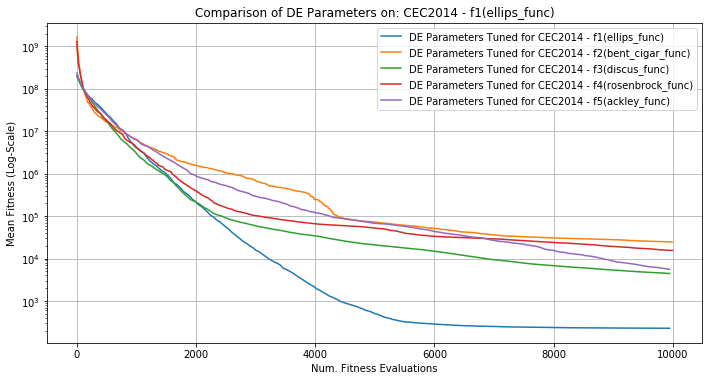

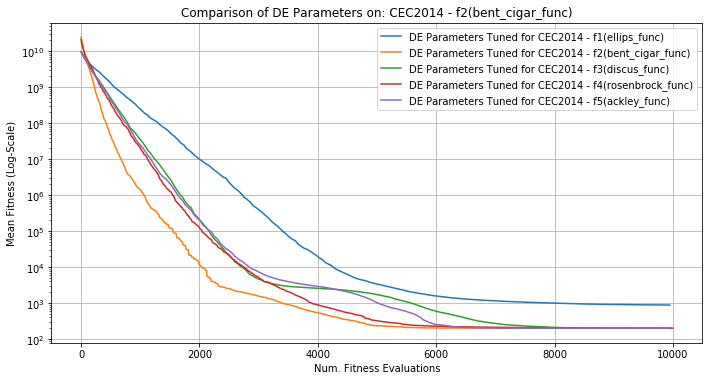

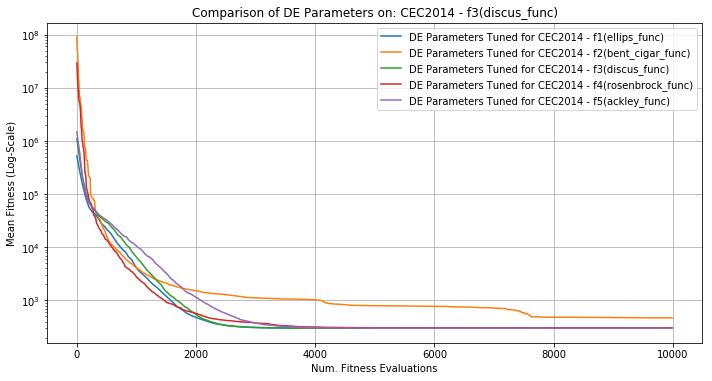

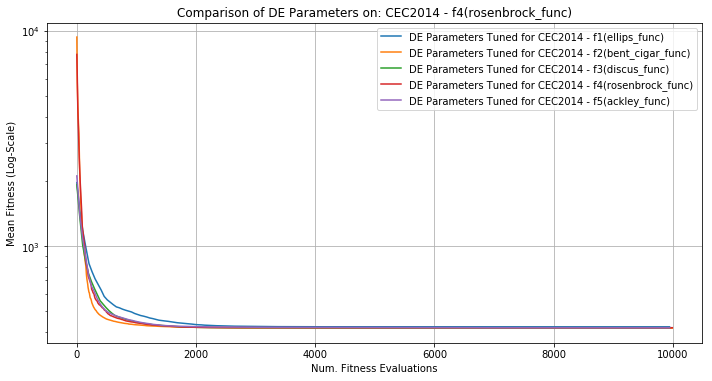

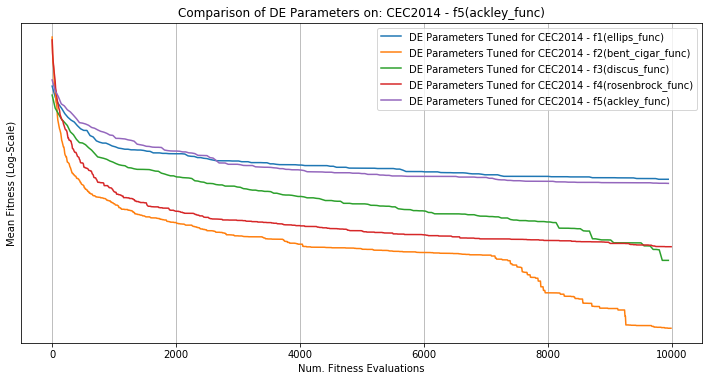

In [22]:
for i in range(num_problems):
    plot_fitness_traces(problem_idx=i, num_runs=50)

## Compromise

When faced with a new problem, we would like to first try and use optimizer parameters that have worked well on many problems in the past. The parameters that we have found using meta-optimization above, were tuned to perform well on multiple problems. This gave us many different choices of parameters with varying performance on the different problems. If we select the parameters that performed best on one problem, then they may perform poorly on another problem.

We need to select a good compromise for the parameters. One way of doing this, is to select the parameters that generally perform best on most problems. This can be done by ranking the parameters according to their performance on each problem, and then selecting the parameters whose overall rank is the best.

We need a few helper-functions for finding these parameters and plotting their performance.

In [23]:
def get_parameters_compromise():
    """Get the 'best' compromise parameters."""
    
    # We find the 'best' compromise parameters by summing
    # their performance ranks on the individual problems.

    # The best_parameters array is already sorted
    # according to the meta-fitness on the first problem,
    # so we just init the ranks with increasing numbers,
    # corresponding to the ranks on the first problem.
    rank_sum = np.arange(len(best_meta_fitness))

    # For each remaining problem.
    for i in range(1, num_problems):
        # The performance rank for the i'th problem,
        # which tells us how well the different parameters
        # performed on the i'th problem.
        rank = np.argsort(best_meta_fitness[:, i])
        
        # Add the rank for the i'th problem to the sum.
        rank_sum += rank

    # The 'best' compromise parameters are the ones that
    # have the best (i.e. lowest) rank sum, so find its index.
    idx = np.argmin(rank_sum)

    # Get those parameters and unpack them.
    parameters = unpack_parameters(best_parameters[idx])
        
    return parameters

In [24]:
def plot_compromise(num_runs=50):
    """
    Perform the given number of optimization runs with
    the 'best' compromise parameters for the DE optimizer
    and plot the fitness-traces for the different problems.
    """

    # Create a single plot.
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(211)

    # Get the 'best' compromise parameters.
    params = get_parameters_compromise()

    # Print the parameters.
    print("Parameter Compromise:")
    print_parameters_raw(params=params)

    for problem in problems:
        # Fitness-trace for the compromise parameters.
        trace, steps = \
            multi_fitness_traces(params=params,
                                 problem=problem,
                                 num_runs=num_runs)

        # Plot the fitness traces.
        ax.plot(steps, trace, label=problem.get_name())
    
    # Set y-axis to log-scale.
    ax.set_yscale("log")
    
    # Set plot title and labels.
    ax.set_title("DE Parameter Compromise")
    ax.set_xlabel("Num. Fitness Evaluations")
    ax.set_ylabel("Mean Fitness (Log-Scale)")
    
    # Show legend.
    ax.legend()
    
    # Show grid.
    ax.grid()
    
    # Plot with a compact layout.
    plt.tight_layout()
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

We can now plot the performance of the 'best' compromise parameters, which perform well overall on the given benchmark problems. But it is possible to find parameters that perform better on individual problems at the cost of worse performance on the other problems.

Parameter Compromise:
pop_size: 54
CR: 0.91
F: 0.51
variant: 4 (best/2/exp)


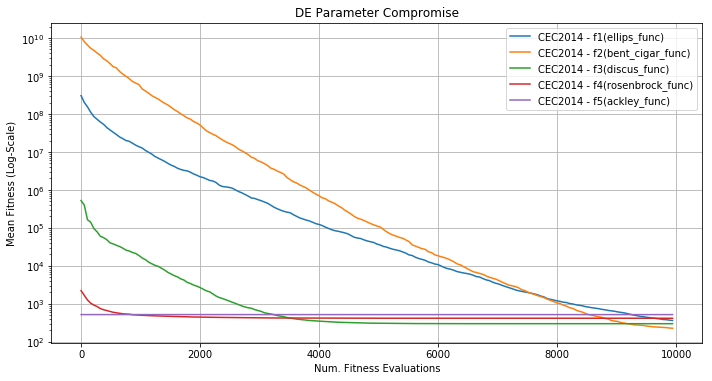

In [25]:
plot_compromise()

## Conclusion

In this paper we used multi-objective meta-optimization to tune the control parameters of Differential Evolution (DE) on several benchmark problems. This resulted in a list of DE parameters that had varying performance on the individual problems.

We then found a set of compromise parameters that performed well overall, but were perhaps not the best choice for any individual problem. These parameters would be a good default choice of parameters for the DE optimizer when trying to optimize a new problem.

This meta-optimization method can also be used when developing new optimizers to rigorously test the optimizer. You can also use the method to find good default choices of parameters tuned for several benchmark problems and long / short optimization runs.

## Exercises & Research Ideas

There are plenty of opportunities for doing original research using these techniques. Here are some ideas to get you started:

- Try running more iterations of the meta-optimizer. Does that improve the results?

- Tune the parameters of another optimizer such as Particle Swarm Optimization (PSO) or Genetic Algorithm (GA).

- Compare the parameters we found above using meta-optimization to some standard parameters recommended in the research literature. Also try and compare the performance on benchmark problems for which the parameters weren't tuned.

- Try using many more benchmark problems in meta-optimization, e.g. 10, 20 or 30 problems. Note that the NSGA-2 method was only intended for 2-3 objectives, which is called *multi-objective* optimization. Having 4 or more objectives is called *many-objective* optimization which poses challenges that NSGA-2 may not handle so well. You may need to use NSGA-3 or another *many-objective* optimizer to handle that many objectives, but these are currently not implemented in Pygmo.

- Plot the Pareto front using the source-code from the [second paper](https://github.com/Hvass-Labs/MetaOps/blob/master/02_Multi-Objective_Meta-Optimization.ipynb). It does not work so well for 3 or more objectives. Can you find a better way to plot the Pareto front, or another way of visualizing the results?

- In addition to using multiple benchmark problems, also try and use objectives for both longer and shorter optimization runs for those problems.

- Instead of using `@lru_cache` on the `meta_fitness()` function, make your own cache-function which first performs e.g. 8 optimization runs and then returns the average fitness of those runs. On the next call it performs another 8 runs and returns the mean of the total 16 runs, and so forth until e.g. 128 runs have been performed. This may both speed up the meta-optimization as well as improve the accuracy, because poor choices of DE parameters will have few runs, while good choices of parameters will have many runs to accurately distinguish similar parameters from each other.

## License (MIT)

Copyright (c) 2018 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.